## FRB180301 Dispersion Relations

Dispersion relation fits: linear (nu^-1), quadratic (nu^-2), best fit (nu^-X), exponential

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
import matplotlib

import dedispersion
import filterbankio
import frbutils

%matplotlib inline

In [2]:
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})

In [3]:
# Dispersion constant in MHz^2 s / pc cm^-3
_D = 4.148808e3

def delay(freq, amp, alpha):
    """
    Calculate the relative delay due to dispersion over a given frequency
    range in Hz for a particular dispersion measure in pc cm^-3.  Return 
    the dispersive delay in seconds.
    
    .. versionchanged:: 1.1.1
    If only a single frequency is provided, the returned delay is 
    relative to infinite frequency.
    """
    
    # Validate in input frequencies
    ## Right Type?
    try:
        freq.size
    except AttributeError:
        freq = np.array(freq, ndmin=1)
    ## Right size?
    singleFreq = False
    if freq.size == 1:
        singleFreq = True
        freq = np.append(freq, np.inf)

    # Delay in s
    tDelay = amp*((1e6/freq)**alpha - (1e6/freq.max())**alpha)
    
    # Cleanup
    if singleFreq:
        tDelay = tDelay[0]
        
    return tDelay

def incoherent(freq, waterfall, tInt, amp, alpha, boundary='wrap', fill_value=np.nan):
    """
    Given a list of frequencies in Hz, a 2-D array of spectra as a function of
    time (time by frequency), and an integration time in seconds, perform 
    incoherent dedispersion on the data.
    
    The 'boundary' keyword is used to control how the boundary is treated.  The
    two options are:
      * wrap - Wrap the time boundary for each frequency (default)
      * fill - Fill the data not within the dedispersed time range with
        the value specified by the 'fill_value' keyword
    
    .. versionchanged:: 1.0.3
        Added in options for handling the boundary conditions
    """
    
    # Validate the boundary mode
    if boundary not in ('wrap', 'fill'):
        raise ValueError("Unknown boundary handling type '%s'" % boundary)
        
    # Compute the dispersive delay for the given frequency range
    tDelay = delay(freq, amp, alpha)
    
    # Convert the delays to integration periods
    tDelay = np.round(tDelay / tInt)
    tDelay = tDelay.astype(np.int32)
    
    # Roll the various frequency bins by the right amount
    ddWaterfall = waterfall*0.0
    for i,d in enumerate(tDelay):
        ddWaterfall[:,i] = np.roll(waterfall[:,i], -d)
        if boundary == 'fill' and d > 0:
            ddWaterfall[-d:,i] = fill_value

    # Return
    return ddWaterfall

In [4]:
frbStr = 'FRB180301'
frbFil = '/home/griffin/local/data/FRB/FRB180301/FRB180301.fil' # Filterbank file of FRB event (aslxlap07)
#frbFil = '/home/griffin/data/FRB/FRB180301/FRB180301.fil' # Filterbank file of FRB event (watermark)

In [5]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 521.

start_time = 2.82 # seconds
time_window = 1. # seconds

applyGauss = True
fGauss = 1. # bins
tGauss = 1 # bins

rfi = []
#rfi = [[205,235], [940,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

normalize = True

In [6]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [7]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)
startIdx = np.argmax(ddTimeSeries)
startTime = startIdx * tInt # seconds

In [8]:
if normalize:
    decddwaterfall = decddwaterfall - np.mean(decddwaterfall, axis=0)
    decwaterfall = decwaterfall - np.mean(decwaterfall, axis=0)

54 123


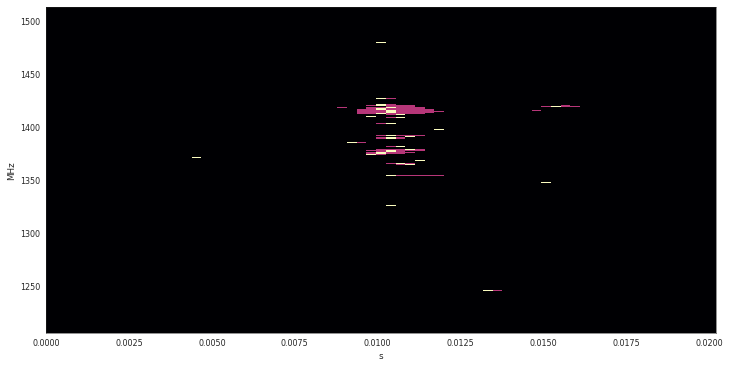

In [9]:
# Find peaks in dedispersed dynamic spectrum
# assuming a near nu^-2 relation, but pick a wide region to allow for variation
peakSearchWidth = .02 # s, time width to find peaks
peakStartTime = startTime - (peakSearchWidth / 2.)
peakStartIdx = int(peakStartTime / tInt)
peakStopTime = startTime + (peakSearchWidth / 2.)
peakStopIdx = int(peakStopTime / tInt)
print peakStartIdx, peakStopIdx

cutoutDynamicSpectrum = np.copy(decddwaterfall[peakStartIdx:peakStopIdx].T)
cutoutDynamicSpectrum -= np.mean(cutoutDynamicSpectrum)

snrThresh = 3.
stdDSpec = np.std(cutoutDynamicSpectrum)

delays = dedispersion.delay(freqs * 1e6, dm) # seconds
#print delays

binaryMask = np.where(cutoutDynamicSpectrum > snrThresh * stdDSpec, 0.5, 0)

validFidx = []
validTidx = []
validDelays = []
validSNR = []

for fIdx in np.arange(cutoutDynamicSpectrum.shape[0]): # loop over frequency channels
    subband = cutoutDynamicSpectrum[fIdx]
    # select only pixels above a threshold
    subPeakIdx = np.argmax(subband)
    if (subband[subPeakIdx] > snrThresh * stdDSpec):
        binaryMask[fIdx, subPeakIdx] = 1.
        validFidx.append(fIdx)
        validTidx.append(subPeakIdx)
        validSNR.append(subband[subPeakIdx] / stdDSpec)

validFreqs = freqs[validFidx]
validDelays = (np.array(validTidx) * tInt) - (peakSearchWidth / 2.) + delays[validFidx] + startTime
validSNR = np.array(validSNR)
#print validFreqs # MHz
#print validDelays # seconds
#print validSNR

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(binaryMask), extent=(0, tInt*cutoutDynamicSpectrum.shape[1],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('MHz')
plt.xlabel('s')

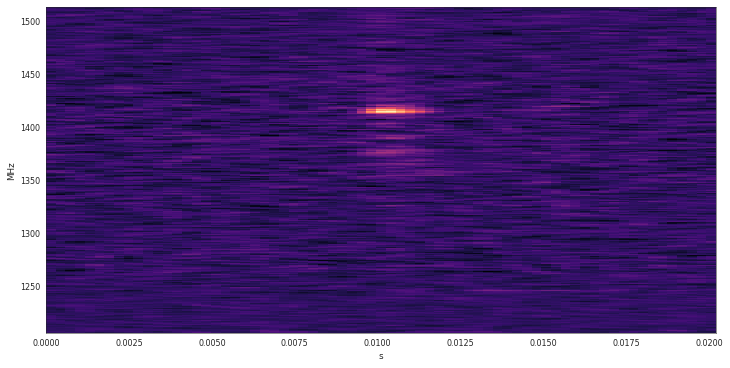

In [10]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(cutoutDynamicSpectrum), extent=(0, tInt*cutoutDynamicSpectrum.shape[1],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')
plt.xlabel('s')

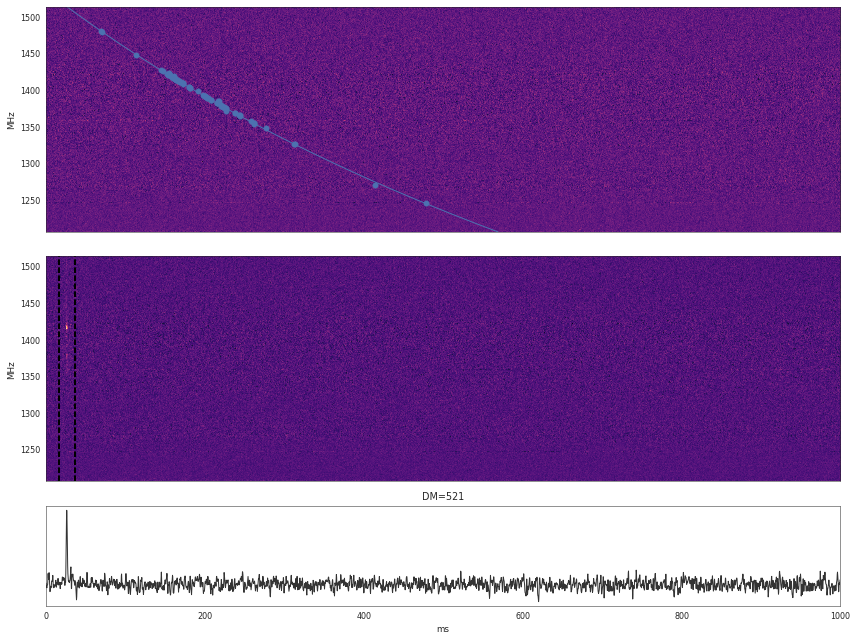

In [11]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,9)) # (width, height)

ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)

plt.scatter(validDelays, validFreqs)

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((5, 3), (2, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.axvline(x=peakStartTime, c='k', lw=2, ls='--')
plt.axvline(x=peakStopTime, c='k', lw=2, ls='--')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax2.get_xaxis().set_visible(False)

ax3 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax3.get_yaxis().set_visible(False)

plt.tight_layout()

#### Build Generic Power Law Model

In [12]:
model = lmfit.models.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff', independent_vars=['nu1', 'nu2'])

print model
print model.param_names
print model.independent_vars

<lmfit.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff')>
['amp', 'alpha', 'toff']
['nu1', 'nu2']


In [13]:
nu1 = validFreqs.copy()
nu2 = np.ones_like(validFreqs) * freqs[-1]

In [14]:
params = model.make_params(amp=dm * 4.148808e3, alpha=-2., toff=-1.*startTime)
#params['alpha'].set(min=-2.5, max=-1.5)
print params

Parameters([('amp', <Parameter 'amp', 2161528.968, bounds=[-inf:inf]>), ('alpha', <Parameter 'alpha', -2.0, bounds=[-inf:inf]>), ('toff', <Parameter 'toff', -0.026038857142857141, bounds=[-inf:inf]>)])


In [15]:
#print model.eval(params, nu1=nu1, nu2=nu2)
#print validDelays

In [16]:
out  = model.fit(validDelays, params, nu1=nu1, nu2=nu2, weights=validSNR)
print out.fit_report()

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # function evals   = 334
    # data points      = 82
    # variables        = 3
    chi-square         = 0.004
    reduced chi-square = 0.000
    Akaike info crit   = -812.903
    Bayesian info crit = -805.682
[[Variables]]
    amp:     8.8688e+05 +/- 7.66e+05 (86.38%) (init= 2161529)
    alpha:  -1.86713191 +/- 0.129187 (6.92%) (init=-2)
    toff:   -0.02506370 +/- 0.001293 (5.16%) (init=-0.02603886)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, alpha)                = -1.000 
    C(alpha, toff)               =  0.919 
    C(amp, toff)                 = -0.918 



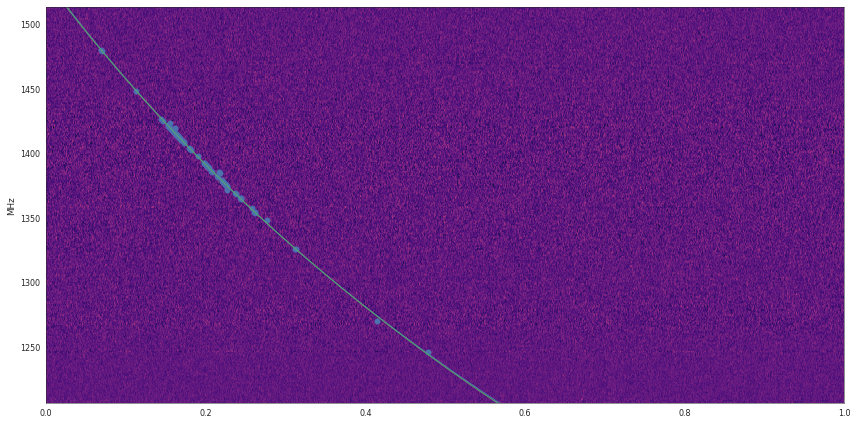

In [17]:
alphaBest = out.best_values['alpha']
ampBest = out.best_values['amp']
toffBest = out.best_values['toff']
nu1Full = freqs
nu2Full = freqs[-1]

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)
plt.plot(ampBest * (nu1Full**(alphaBest) - nu2Full**(alphaBest)) - toffBest, freqs)


plt.scatter(validDelays, validFreqs)

plt.tight_layout()

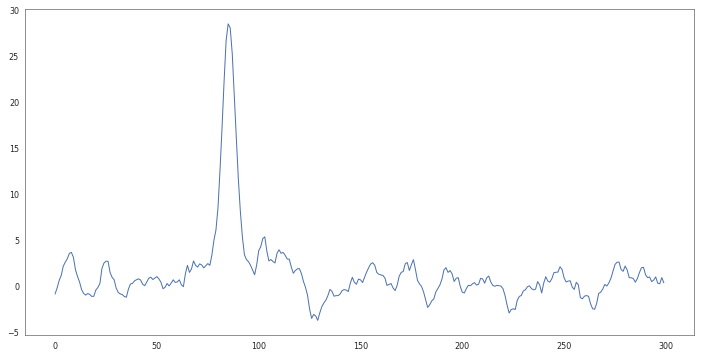

In [18]:
ddwaterfall0 = incoherent(freqs * 1e6, decwaterfall, tInt, ampBest, -1. * alphaBest, boundary='wrap') # apply dedispersion
fig = plt.figure(figsize=(12,6)) # (width, height)
nuBestts = ddwaterfall0.mean(axis=1)
plt.plot(nuBestts[:300])

#### Build nu^-2 Power Law Model

In [19]:
model = lmfit.models.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff', independent_vars=['nu1', 'nu2', 'alpha'])

print model
print model.param_names
print model.independent_vars

<lmfit.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff')>
['amp', 'toff']
['nu1', 'nu2', 'alpha']


In [20]:
nu1 = validFreqs.copy()
nu2 = np.ones_like(validFreqs) * freqs[-1]
alpha = -2.

In [21]:
params = model.make_params(amp=dm * 4.148808e3, toff=-1.*startTime)
print params

Parameters([('amp', <Parameter 'amp', 2161528.968, bounds=[-inf:inf]>), ('toff', <Parameter 'toff', -0.026038857142857141, bounds=[-inf:inf]>)])


In [22]:
out  = model.fit(validDelays, params, nu1=nu1, nu2=nu2, alpha=alpha, weights=validSNR)
print out.fit_report()

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # function evals   = 8
    # data points      = 82
    # variables        = 2
    chi-square         = 0.004
    reduced chi-square = 0.000
    Akaike info crit   = -813.811
    Bayesian info crit = -808.997
[[Variables]]
    amp:    2.1613e+06 +/- 7.10e+03 (0.33%) (init= 2161529)
    toff:  -0.02628443 +/- 0.000505 (1.92%) (init=-0.02603886)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, toff)                 =  0.972 



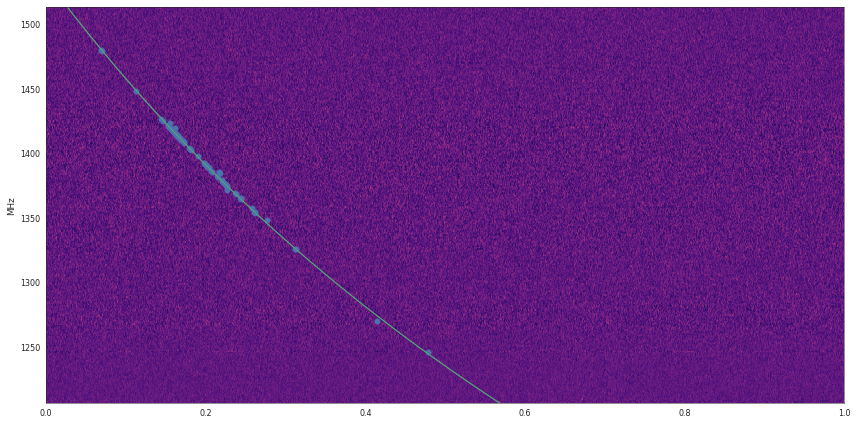

In [23]:
alphaBest = -2.
ampBest = out.best_values['amp']
toffBest = out.best_values['toff']
nu1Full = freqs
nu2Full = freqs[-1]

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)
plt.plot(ampBest * (nu1Full**(alphaBest) - nu2Full**(alphaBest)) - toffBest, freqs)


plt.scatter(validDelays, validFreqs)

plt.tight_layout()

In [24]:
ddwaterfall0 = incoherent(freqs * 1e6, decwaterfall, tInt, dm * _D, -2. * -1., boundary='wrap') # apply dedispersion

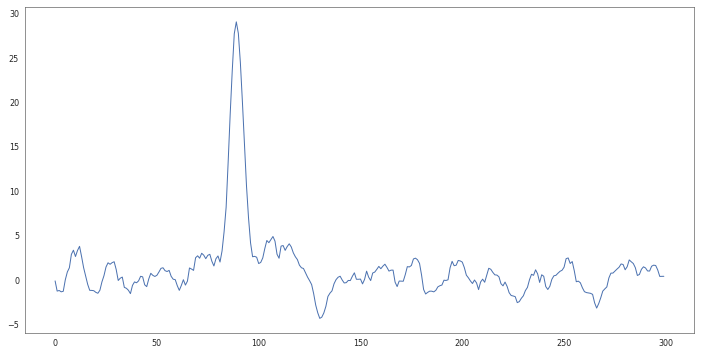

In [25]:
fig = plt.figure(figsize=(12,6)) # (width, height)
nu2ts = ddwaterfall0.mean(axis=1)
plt.plot(nu2ts[:300])

#### Build nu^-1 Power Law Model

In [26]:
model = lmfit.models.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff', independent_vars=['nu1', 'nu2', 'alpha'])

print model
print model.param_names
print model.independent_vars

<lmfit.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff')>
['amp', 'toff']
['nu1', 'nu2', 'alpha']


In [27]:
nu1 = validFreqs.copy()
nu2 = np.ones_like(validFreqs) * freqs[-1]
alpha = -1.

In [28]:
params = model.make_params(amp=3000., toff=-1.*startTime)
print params

Parameters([('amp', <Parameter 'amp', 3000.0, bounds=[-inf:inf]>), ('toff', <Parameter 'toff', -0.026038857142857141, bounds=[-inf:inf]>)])


In [29]:
out  = model.fit(validDelays, params, nu1=nu1, nu2=nu2, alpha=alpha, weights=validSNR)
print out.fit_report()

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # function evals   = 8
    # data points      = 82
    # variables        = 2
    chi-square         = 0.006
    reduced chi-square = 0.000
    Akaike info crit   = -778.458
    Bayesian info crit = -773.644
[[Variables]]
    amp:    3155.05115 +/- 12.85969 (0.41%) (init= 3000)
    toff:  -0.01697083 +/- 0.000664 (3.91%) (init=-0.02603886)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, toff)                 =  0.975 



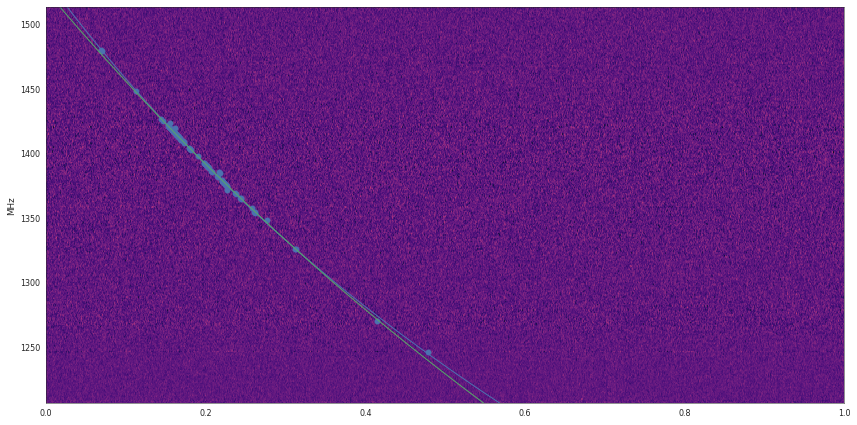

In [30]:
alphaBest = -1.
ampBest = out.best_values['amp']
toffBest = out.best_values['toff']
nu1Full = freqs
nu2Full = freqs[-1]

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)
plt.plot(ampBest * (nu1Full**(alphaBest) - nu2Full**(alphaBest)) - toffBest, freqs)


plt.scatter(validDelays, validFreqs)

plt.tight_layout()

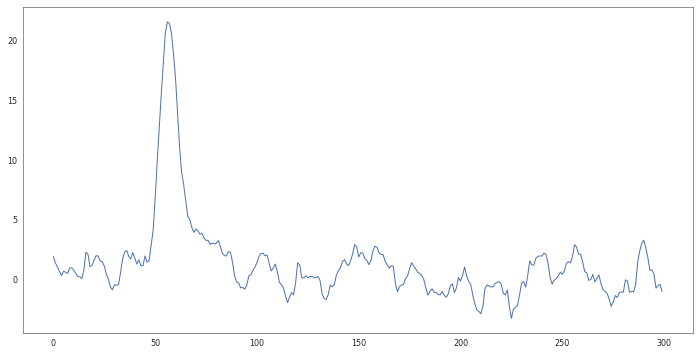

In [31]:
ddwaterfall0 = incoherent(freqs * 1e6, decwaterfall, tInt, ampBest, -1. * -1., boundary='wrap') # apply dedispersion
fig = plt.figure(figsize=(12,6)) # (width, height)
nu1ts = ddwaterfall0.mean(axis=1)
plt.plot(nu1ts[:300])

#### Build nu^-3 Power Law Model

In [32]:
model = lmfit.models.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff', independent_vars=['nu1', 'nu2', 'alpha'])

print model
print model.param_names
print model.independent_vars

<lmfit.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff')>
['amp', 'toff']
['nu1', 'nu2', 'alpha']


In [33]:
nu1 = validFreqs.copy()
nu2 = np.ones_like(validFreqs) * freqs[-1]
alpha = -3.

In [34]:
params = model.make_params(amp=3000., toff=-1.*startTime)
print params

Parameters([('amp', <Parameter 'amp', 3000.0, bounds=[-inf:inf]>), ('toff', <Parameter 'toff', -0.026038857142857141, bounds=[-inf:inf]>)])


In [35]:
out  = model.fit(validDelays, params, nu1=nu1, nu2=nu2, alpha=alpha, weights=validSNR)
print out.fit_report()

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # function evals   = 11
    # data points      = 82
    # variables        = 2
    chi-square         = 0.008
    reduced chi-square = 0.000
    Akaike info crit   = -758.346
    Bayesian info crit = -753.532
[[Variables]]
    amp:    1.9693e+09 +/- 9.08e+06 (0.46%) (init= 3000)
    toff:  -0.03530680 +/- 0.000668 (1.89%) (init=-0.02603886)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, toff)                 =  0.969 



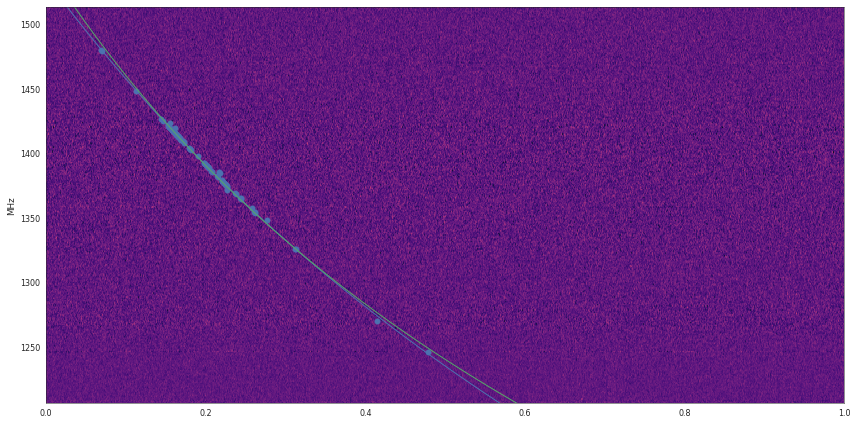

In [36]:
alphaBest = -3.
ampBest = out.best_values['amp']
toffBest = out.best_values['toff']
nu1Full = freqs
nu2Full = freqs[-1]

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)
plt.plot(ampBest * (nu1Full**(alphaBest) - nu2Full**(alphaBest)) - toffBest, freqs)


plt.scatter(validDelays, validFreqs)

plt.tight_layout()

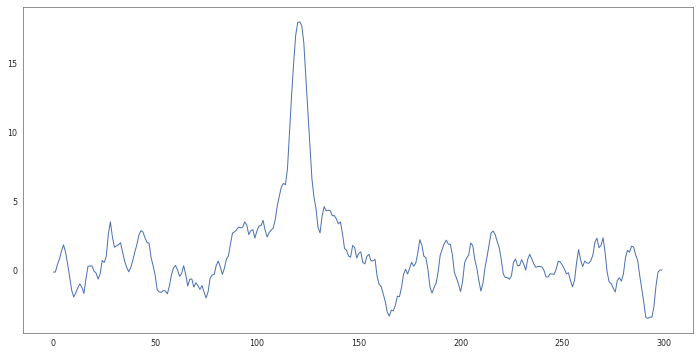

In [37]:
ddwaterfall0 = incoherent(freqs * 1e6, decwaterfall, tInt, ampBest, -1. * -3., boundary='wrap') # apply dedispersion
fig = plt.figure(figsize=(12,6)) # (width, height)
nu3ts = ddwaterfall0.mean(axis=1)
plt.plot(nu3ts[:300])

#### Build nu^-1.8 Power Law Model

In [38]:
model = lmfit.models.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff', independent_vars=['nu1', 'nu2', 'alpha'])

print model
print model.param_names
print model.independent_vars

<lmfit.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff')>
['amp', 'toff']
['nu1', 'nu2', 'alpha']


In [39]:
nu1 = validFreqs.copy()
nu2 = np.ones_like(validFreqs) * freqs[-1]
alpha = -2.1

In [40]:
params = model.make_params(amp=3000., toff=-1.*startTime)
print params

Parameters([('amp', <Parameter 'amp', 3000.0, bounds=[-inf:inf]>), ('toff', <Parameter 'toff', -0.026038857142857141, bounds=[-inf:inf]>)])


In [41]:
out  = model.fit(validDelays, params, nu1=nu1, nu2=nu2, alpha=alpha, weights=validSNR)
print out.fit_report()

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 82
    # variables        = 2
    chi-square         = 0.004
    reduced chi-square = 0.000
    Akaike info crit   = -811.587
    Bayesian info crit = -806.774
[[Variables]]
    amp:    4.2379e+06 +/- 1.41e+04 (0.33%) (init= 3000)
    toff:  -0.02719979 +/- 0.000509 (1.87%) (init=-0.02603886)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, toff)                 =  0.972 



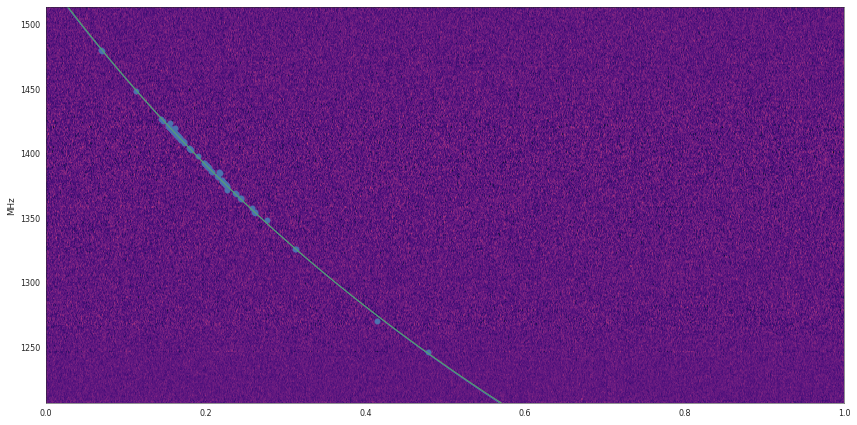

In [42]:
alphaBest = -2.1
ampBest = out.best_values['amp']
toffBest = out.best_values['toff']
nu1Full = freqs
nu2Full = freqs[-1]

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)
plt.plot(ampBest * (nu1Full**(alphaBest) - nu2Full**(alphaBest)) - toffBest, freqs)


plt.scatter(validDelays, validFreqs)

plt.tight_layout()

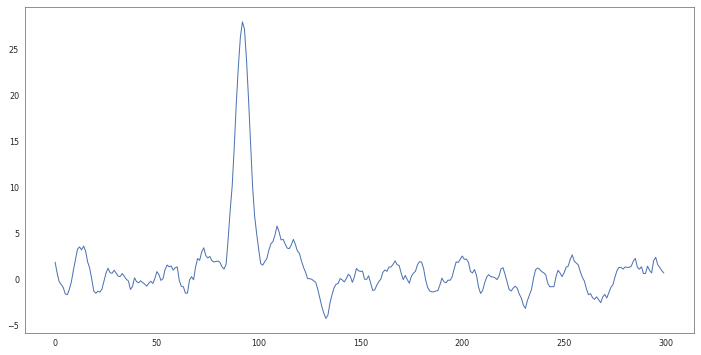

In [43]:
ddwaterfall0 = incoherent(freqs * 1e6, decwaterfall, tInt, ampBest, -1. * -2.1, boundary='wrap') # apply dedispersion
fig = plt.figure(figsize=(12,6)) # (width, height)
nuTestts = ddwaterfall0.mean(axis=1)
plt.plot(nuTestts[:300])

#### Profile Plots

(0, 200)

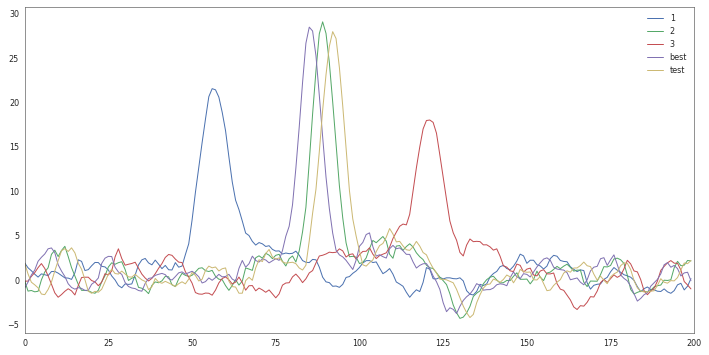

In [44]:
fig = plt.figure(figsize=(12,6)) # (width, height)

plt.plot(nu1ts[:200], label='1')
plt.plot(nu2ts[:200], label='2')
plt.plot(nu3ts[:200], label='3')
plt.plot(nuBestts[:200], label='best')
plt.plot(nuTestts[:200], label='test')
plt.legend()

plt.xlim(0, 200)